# Sensitivity analysis with DiKErnel
This notebook shows an example to illustrate how to use the dikerosion python toolbox to execute a sensitivity analysis. By varying the orientation of the incoming wave we will investigate the influence of the incoming wave on the calculated damage numbersfor a specific model setup. 

To achieve this we will:
1. [Define a basic model schematization.](#specification-of-our-basic-model)
1. [Define the range of variation for the amount of output locations](#range-of-variation).
1. [Perform calculations in batch](#perform-calculations-and-store-results)
1. [Visualize the output](#visualize-results)

<div class="alert alert-block alert-info">
<b>Not necessary:</b> The following code makes sure that also during development the toolbox can be adressed properly.
</div>

In [1]:
import sys
import os

sys.path.append(os.path.dirname(os.getcwd()))

# Specification of our basic model
We start our sensitivity analysis with the definition of a basic model run. 

Setting up an extensive model is part of the notebook example_elaborate. Here we will quickly initialize a model set up and input.

### Dike schematization
First we define the dike schematization.

In [2]:
import pydrever.data as dedata

x_positions = [0.0, 24.0, 35.0, 41.0, 45.01, 50, 60, 70]
z_positions = [-3, 0.0, 1.5, 1.7, 3.0, 3.1, 0, -1]
roughnesses = [1, 1, 0.75, 0.5, 0.8, 0.8, 0.8]
dike_schematization = dedata.DikeSchematization(
    dike_orientation=0.0, 
    x_positions=x_positions, 
    z_positions=z_positions, 
    roughnesses=roughnesses, 
    x_outer_toe=24.0, 
    x_outer_crest=45.01
)

### Hydrodynamic conditions
Lateron we would like to create hydraulic conditions as input for different wave angles. We therefore create a function here that produces these hydrodynamic conditions.

This function can lateron be called with just one input variable (the desired wave angle) and will give a similar set of hydrodynamic conditions with the specified wave angle.

In [3]:
import numpy
from pydrever.data import HydrodynamicConditions

def create_hydrodynamic_conditions(wave_start_angle:float = -20) -> HydrodynamicConditions:
    n_steps = 100
    time_steps = numpy.linspace(
        0.0, 126000.0, int(126000.0 / n_steps), dtype=float, endpoint=True
    )

    phase_water_levels = numpy.pi / 64.0
    amplitude_water_levels = 1.3
    minimum_water_level = 0.5
    water_levels = (
        amplitude_water_levels
        * (1 - numpy.cos(time_steps[1:] / 1000.0 * phase_water_levels))
        + minimum_water_level
    )

    phase_wave_heights = numpy.pi / 32.0
    ampltude_waves = 0.2
    minimum_wave_height = 0.8
    wave_heights = (
        ampltude_waves * (1 - numpy.cos(time_steps[1:] / 1000.0 * phase_wave_heights))
        + minimum_wave_height
    )

    wave_periods = 7.0 + time_steps[1:] / 1000.0 * 0.05
    
    wave_start_angle = ((wave_start_angle % 360) + 360) % 360
    wave_directions = wave_start_angle + time_steps[1:] * 0.0

    hydrodynamic_conditions = HydrodynamicConditions(
        time_steps=time_steps, 
        water_levels=water_levels, 
        wave_heights=wave_heights, 
        wave_periods=wave_periods, 
        wave_directions=wave_directions
    )

    return hydrodynamic_conditions

### Output locations
Lets assume our dike is completely covered with a grass revetment and is very well maintained. We don't expect any overtopping during this storm, so we are only interested in wave impact on our grass revetment.

We can now define a base for our output locations. Next to that, we will only look at the zone between x = 25m and x = 45m.

In [4]:
base_layer_specification = dedata.GrassWaveImpactLayerSpecification(top_layer_type=dedata.TopLayerType.GrassClosedSod)
base_x_min = 25.00
base_x_max = 45.00


Now we define a function that we can use to generate output location specifications within our zone of interes. This method uses the specified base output location specification and generates similat (copied) locations depending on the desired resolution between the minimum and maximum of the zone of interest. 

In [5]:
def create_output_specifications(step_size:float) -> list[dedata.OutputLocationSpecification]:
    n_locations = numpy.ceil((base_x_max - base_x_min) / step_size) + 1
    x_positions = numpy.linspace(base_x_min, base_x_max, n_locations.astype(int))
    return [dedata.OutputLocationSpecification(x_position=x_position,top_layer_specification=base_layer_specification) for x_position in x_positions]

The following code uses this funtion to generate a set of output locations at every meter (cross-shore).

In [6]:
output_locations = create_output_specifications(1)

### Calculation settings
To keep this example clean, we will use the default settings of DiKErnel. This is achieved by leaving the settings field empty.

# Range of variation
In this example we will vary the direction of the incoming waves. We therefore define a list of wave angles for which we would like to perform a calculation.

In [7]:
wave_angles = [-40.0, -30.0, -20.0, -10.0, 0.0, 10.0, 20.0, 30.0, 40.0]

# Perform calculations and store results
It is now time to run calculations in batch mode. We therefore loop over the specified directions. For each direction we generate calculation input, validate and run the calculation. We then store basic output for each of the calculations.

In [8]:
from pydrever.calculation import Dikernel

wave_angle_output = {}

for wave_angle in wave_angles:
    hydrodynamic_conditions_new = create_hydrodynamic_conditions(wave_angle)
    calculation_input = dedata.DikernelInput(dike_schematization=dike_schematization, hydrodynamic_input=hydrodynamic_conditions_new)
    calculation_input.output_locations = output_locations

    kernel = Dikernel(calculation_input)
    kernel.run()

    calculated_damage = [l.damage_development[-1] for l in kernel.output]
    wave_angle_output[wave_angle] = {
        "x_positions": [l.x_position for l in kernel.output],
        "damage_numbers": calculated_damage,
        "max_damage": max(calculated_damage),
    }

# Visualize results
It's now time to visualize. Let's show the calculated maximum damage for each wave angle.


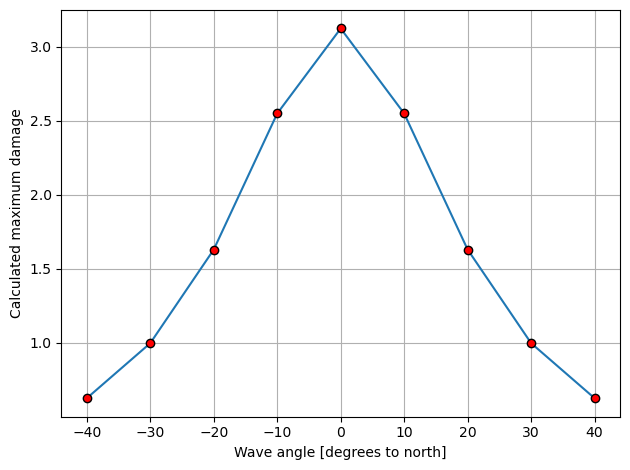

In [9]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = plt.subplot(1,1,1)
ax.plot(
    wave_angle_output.keys(),
    [o["max_damage"] for o in wave_angle_output.values()],
    marker="o",
    markerfacecolor='red',
    markeredgecolor='black',
    linestyle="solid",
)
ax.set_xlabel('Wave angle [degrees to north]')
ax.set_ylabel('Calculated maximum damage')
ax.grid()
fig.tight_layout()
plt.show()

To get more feeling on the influence of the wave orientation of the damage development, we can also compare all calculated damage levels along the zone of interest for each orientation of the wave angle.

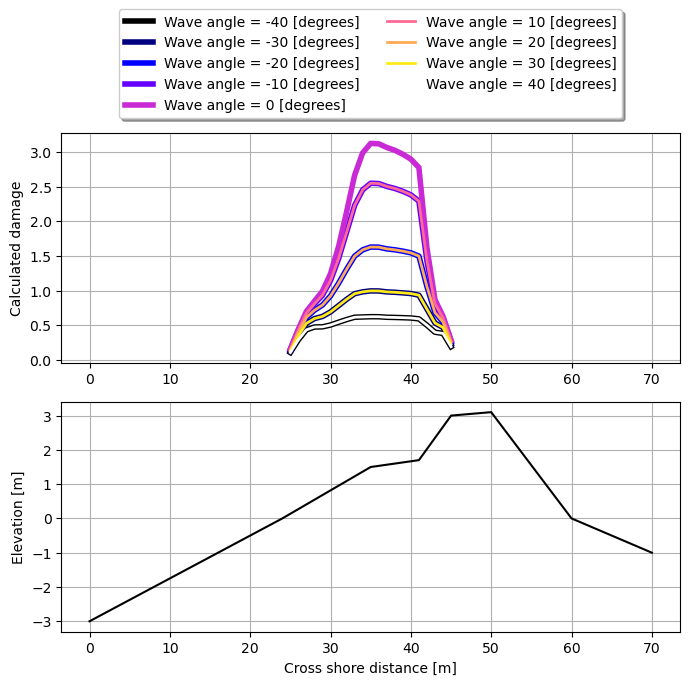

In [10]:
colors = plt.cm.gnuplot2(numpy.linspace(0, 1, len(wave_angle_output)))

fig = plt.figure(figsize=(7, 7))
ax1 = plt.subplot(2,1,1)

for i_out, out in enumerate(wave_angle_output.values()):
    ax1.plot(
        out["x_positions"],
        out["damage_numbers"],
        color=colors[i_out],
        linewidth= 2.0 if (wave_angles[i_out] > 0.0) else 4.0,
        label="Wave angle = %0.0f [degrees]" % list(wave_angle_output)[i_out]
    )
ax1.grid()
ax1.set(ylabel="Calculated damage")
ax1.legend(bbox_to_anchor=(0.5, 1.3),loc="center",
          fancybox=True, shadow=True, ncol=2)

ax2 = plt.subplot(2,1,2, sharex=ax1)
ax2.plot(
    x_positions,
    z_positions,
    color="black"
)
ax2.grid()
ax2.set(xlabel="Cross shore distance [m]", ylabel="Elevation [m]")
fig.tight_layout()
plt.show()